# Hospice Utilization by Minorites
## Investigator: J. Patrick Bernard
## MSDS692 DataSciencePracticum 2

### Purpose:  
The purpose of my project is to investigate utilization of Hospice care by minority racial groups. There is a history of racial groups having lower levels of access to medical care. Is also true for hospice care? My goal is not to explain why or how this is occurring, that is the job of social and healthcare professionals. My goal is to collect and evaluate the data so that these professionals can direct their effort in the best way possible.  the region of concern will be Louisiana and Mississippi.  

### Data Source:  
2018 Medicare hospice claims.  

### Data Classifier Develoment

In this notebook I develop the model using a sample set of data from all of the states files.

In the CreateStatePickleFiles notbook I divided the entire data set by state saving that data in a seperate file.  


**References**  
https://dataaspirant.com/random-forest-algorithm-machine-learing/  
https://machinelearningmastery.com/implement-random-forest-scratch-python/  
https://machinelearningmastery.com/random-forest-ensemble-in-python/  
https://www.datacamp.com/community/tutorials/random-forests-classifier-python  
https://www.datacamp.com/community/tutorials/random-forests-classifier-python#building  


In [13]:
# packages
import pandas as pd
import numpy as np
from numpy.random import randint
import re
import csv
import os
import pickle
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns

In [14]:
#format the work space
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [15]:
# These are the dictionary descriptions for the categorical data
states = {1:'Alabama',2:'Alaska',3:'Arizona',4:'Arkansas',5:'California',6:'Colorado',7:'Connecticut',8:'Delaware',
          9:'DistOCol',10:'Florida',11:'Georgia',12:'Hawaii',13:'Idaho',14:'Illinois',15:'Indiana',16:'Iowa',17:'Kansas',
          18:'Kentucky',19:'Louisiana',20:'Maine',21:'Maryland',22:'Massachusetts',23:'Michigan',24:'Minnisota',
          25:'Mississippi',26:'Missouri',27:'Montana',28:'Nebraska',29:'Nevada',30:'NewHampshire',31:'NewJersey',
          32:'NewMexico',33:'NewYork',34:'NorthCarolina',35:'NorthDakota',36:'Ohio',37:'Oklahoma',38:'Oregon',39:'Pennsylvainia',
          40:'PuertoRico',41:'RhodeIsland',42:'SouthCarolina',43:'SouthDakota',44:'Tennessee',45:'Texas',46:'Utah',47:'Vermont',
          48:'VirginIsland',49:'Virginia',50:'Washington',51:'WestVirgina',52:'Wisconson',53:'Wyoming',54:'Africa',55:'Canada_Islands',
          56:'CentAmerWstInd',57:'Europe',58:'Mexico',59:'Oceania',60:'Philippines',61:'SouthAmerica',62:'UsPosessions',
          63:'AmericanSamoa',64:'Guam',65:'SaipanNorthMarianas',97:'NorthernMarianas',98:'Guam',99:'Unknown'}
Race = {0:'Unknown', 1:'White',2:'Black',3:'Other',4:'Asian',5:'Hispanic',6:'North_American_Native'}
Race_WBAllOther  = {1:'White',2:'Black',3:'All Other'}
AgeGroups = {0:'Unknown',1:'<64',2:'64-69',3:'70-74',4:'75-79',5:'80-84',6:'>84'}
PTDCSTUS = {0:'Missing',1:'Still Patient',2:'DC Alive',3:'DC Deceased'}

In [16]:
# D_SSA is a look up table for the county id
SSA = pd.read_csv('e:/PatrickBernard/d_ssa.csv',names = ['county_id', 'county'])
#D_SSA.set_index('county_id',inplace = True)  
SSA.sample(3)

,county_id,county
1302,23700,Presque Isle MI
1203,21090,Dorchester MD
2926,49190,Charlotte VA


In [ ]:
# *** TODO update this to retrieve more than one state OR write this to retrieve one state and then call it
# more than once for each state.

subject_states = [19]#,25]
# compare_states = []  # this may be used latter to derive data for comparison regions

#  with open(f'e:/PatrickBernard/{states[i]}MBSF2018.pkl', 'wb') as f:

for s in subject_states:
    with open(f'e:/PatrickBernard/{states[s]}MBSF2018.pkl', 'rb') as f:
        regional_data = pickle.load(f)


In [ ]:
regional_data.info()

In [ ]:
regional_data.columns

In [ ]:
regional_data.sample(4)

In [5]:
features = ['Bene_ID', 'D_State', 'D_SSA', 'D_SSA2','D_DIED','D_Sex', 'D_Race','D_Age','D_TM', 'D_TM_Died',
            'D_MA_Plan', 'D_MA_Plan_Died','D_HOS_PT', 'D_HOS_PROVIDER_ID','D_HOS_Died','D_HOS_UTIL_DAY',
            'D_INPT_PT', 'D_INPT_PROVIDER_ID','D_INPT_DC_Status', 'D_INPT_Died','D_INPT_UTIL_DAY','D_SNF_PT',
            'D_SNF_PROVIDER_ID','D_SNF_DC_Status', 'D_SNF_Died','D_SNF_UTIL_DAY','D_HHA_PT',
            'D_HHA_PROVIDER_ID','D_HHA_PTDCSTUS', 'D_HHA_DIED','D_HHA_Days']

labels = ['D_HOS_PTDCSTUS']

### Create Classifier

In [5]:
# Import packages for classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Classify on Race

If we use the features in the data can we determine the race of the individual?  

In [17]:

feat_r = ['Bene_ID', 'D_State', 'D_SSA', 'D_SSA2','D_DIED','D_Sex', 'D_Age','D_TM', 'D_TM_Died',
            'D_MA_Plan', 'D_MA_Plan_Died','D_HOS_PT', 'D_HOS_PROVIDER_ID','D_HOS_Died','D_HOS_UTIL_DAY','D_HOS_PTDCSTUS',
            'D_INPT_PT', 'D_INPT_PROVIDER_ID','D_INPT_DC_Status', 'D_INPT_Died','D_INPT_UTIL_DAY','D_SNF_PT',
            'D_SNF_PROVIDER_ID','D_SNF_DC_Status', 'D_SNF_Died','D_SNF_UTIL_DAY','D_HHA_PT',
            'D_HHA_PROVIDER_ID','D_HHA_PTDCSTUS', 'D_HHA_DIED','D_HHA_Days','N_Providers','RANDOM_NUM']

labels_r = ['D_Race']

### Create Training  
Create a model from the traing data set.  

In [18]:
# load the training data set
with open(f'e:/PatrickBernard/training_set.pk2', 'rb') as f:
        training_data = pickle.load(f)
# Create a random number of confounding
training_data['RANDOM_NUM'] = randint(0, 10)
# impute missing data
training_data.fillna(-999, inplace = True)
# build the training and test data sets
X_data = training_data[feat_r]
y_data = training_data['D_Race']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25) # 75% training 25% test

In [19]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Bene_ID,1231279.0,3.905279e+08,1.431194e+08,1.000001e+08,441229571.5,462199812.0,479554645.0,5.000000e+08
D_State,1231279.0,2.516100e+01,1.530869e+01,1.000000e+00,10.0,24.0,38.0,5.300000e+01
D_SSA,1231279.0,2.553068e+04,1.534833e+04,1.000000e+03,10520.0,24610.0,38250.0,5.399900e+04
D_SSA2,1231279.0,1.001389e+00,5.268466e-02,1.000000e+00,1.0,1.0,1.0,3.000000e+00
D_Bene,1231279.0,1.000000e+00,0.000000e+00,1.000000e+00,1.0,1.0,1.0,1.000000e+00
D_DIED,1231279.0,3.678451e-02,1.882324e-01,0.000000e+00,0.0,0.0,0.0,1.000000e+00
D_Sex,1231279.0,1.542926e+00,4.981542e-01,1.000000e+00,1.0,2.0,2.0,2.000000e+00
D_Race,1231279.0,1.339492e+00,9.424640e-01,0.000000e+00,1.0,1.0,1.0,6.000000e+00
D_Race_WBAllOther,1231279.0,1.304202e+00,6.384491e-01,1.000000e+00,1.0,1.0,1.0,3.000000e+00
D_Age,1231279.0,7.045168e+01,1.129256e+01,2.000000e+00,65.0,70.0,77.0,9.800000e+01


In [51]:
len(feat_r)

33

In [20]:
model_r2 = RandomForestClassifier(n_estimators=100, max_depth = 6, min_samples_leaf = 3)

In [21]:
# fit the model to predict on Race
model_r2.fit(X_train,y_train)

y_pred=model_r2.predict(X_test)
pickle.dump(model_r2,open('e:/PatrickBernard/rf_model2.mdl','wb'))

In [22]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_r2, X_data, y_data, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.794 (0.000)


In [24]:
print(f'classes: {model_r2.classes_}\nnum_features: {model_r2.n_features_}\noutputs: {model_r2.n_outputs_} ')

classes: [0 1 2 3 4 5 6]
num_features: 33
outputs: 1 


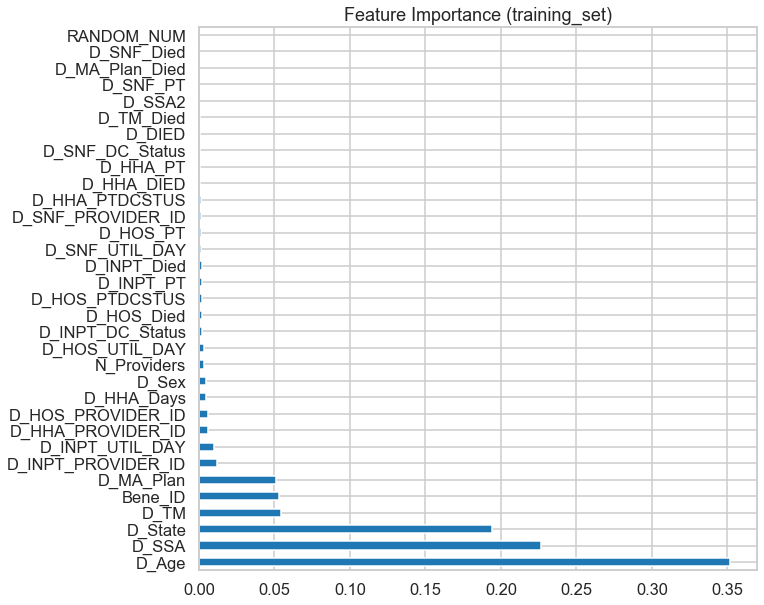

In [52]:
feat_importances = pd.Series(model_r2.feature_importances_, training_data[feat_r].columns)
feat_importances.nlargest(33).plot(kind='barh')
plt.title(f'Feature Importance (training_set)')
plt.savefig(f'e:/PatrickBernard/figures/RF_Class/model2/1training_set_RF_FeatureImportance.png',bbox_inches = 'tight')
plt.show()

In [38]:
# Set the location of the figure
figPath = 'e:/PatrickBernard/figures/RF_Class/'
# Retrieve the model
model_r2 = pickle.load(open('e:/PatrickBernard/rf_model2.mdl','rb'))

for file in os.listdir(f'e:/PatrickBernard/'):
    if file.endswith('.pkl')== False:
        continue
    else:
        with open(f'e:/PatrickBernard/{file}', 'rb') as f:
            regional_data = pickle.load(f)
    print(file)
    # Retrieve the sate identifier
    s = regional_data.iloc[0,1]
    
    # impute missing data
    regional_data.fillna(-999, inplace = True)
    # Create a random number for confounding
    regional_data['RANDOM_NUM'] = randint(0, 10)    
    

    #define the features
    feat_r = ['Bene_ID', 'D_State', 'D_SSA', 'D_SSA2','D_DIED','D_Sex', 'D_Age','D_TM', 'D_TM_Died',
                'D_MA_Plan', 'D_MA_Plan_Died','D_HOS_PT', 'D_HOS_PROVIDER_ID','D_HOS_Died','D_HOS_UTIL_DAY','D_HOS_PTDCSTUS',
                'D_INPT_PT', 'D_INPT_PROVIDER_ID','D_INPT_DC_Status', 'D_INPT_Died','D_INPT_UTIL_DAY','D_SNF_PT',
                'D_SNF_PROVIDER_ID','D_SNF_DC_Status', 'D_SNF_Died','D_SNF_UTIL_DAY','D_HHA_PT',
                'D_HHA_PROVIDER_ID','D_HHA_PTDCSTUS', 'D_HHA_DIED','D_HHA_Days','N_Providers','RANDOM_NUM']

    #labels_r = ['D_Race']

### Obsolete left for Record
#     # build the training and test data sets
#     X_data = regional_data[feat_r]
#     y_data = regional_data['D_Race']
#
#     X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3) # 70% training 30% test
#
#     # Define the model
#     model_r = RandomForestClassifier(n_estimators=100, max_depth = 6, min_samples_leaf = 3)
#
#     fit the model to predict on Hospice discharge status
#     model_r.fit(X_train,y_train)
    
    regional_data['Race_pred'] = model_r2.predict(regional_data[feat_r])

#     feat_importances = pd.Series(model_r.feature_importances_, regional_data[feat_r].columns)
#     feat_importances.nlargest(31).plot(kind='barh')
#     plt.title(f'RF Feature Importance ({states[s]})')
#     plt.savefig(f'{figPath}{states[s]}_RF_FeatureImportance.png',bbox_inches = 'tight')
#     feat_importances['state'] =  states[s]



 # Create a classifiation utilization summary file with data for all the states
    
    s_data = {'state':states[s], 'Tot_record':len(regional_data)}

#     race_count = regional_data.groupby('Race_pred')['Race_pred'].count()

#     sum_Race = {'Pred_unk_tot' : race_count[0], 'Pred_white_tot': race_count[1],'Pred_black_tot':race_count[2],'Pred_other_tot':race_count[3],
#                 'Pred_asian_tot': race_count[4], 'Pred_Hispanic_tot': race_count[5], 'Pred_NA_Native_tot': race_count[6]}

#     s_data.update(sum_Race)

    for i in range (0, 7):
        z_data = {f'Pred_{Race[i]}_alive': len(regional_data[(regional_data.Race_pred == i)  & (regional_data.D_DIED == 0)].index),
        f'Pred_{Race[i]}_deceased' : len(regional_data[(regional_data.Race_pred == i)  & (regional_data.D_DIED == 1)].index),
        f'Pred_{Race[i]}_HOS_alive' : len(regional_data[(regional_data.Race_pred == i)  & (regional_data.D_HOS_Died == 0)].index),
        f'Pred_{Race[i]}_HOS_deceased' : len(regional_data[(regional_data.Race_pred == i)  & (regional_data.D_HOS_Died == 1)].index)}
        
        if z_data[f'Pred_{Race[i]}_deceased'] == 0:
            util = {f'Pred_{Race[i]}_HOS_Utilization' : 0}
        else:
            util = {f'Pred_{Race[i]}_HOS_Utilization' : z_data[f'Pred_{Race[i]}_HOS_deceased']/z_data[f'Pred_{Race[i]}_deceased']}
            
        z_data.update(util)
        s_data.update(z_data)
        

    cols = ['state', 'Tot_record','Pred_Unknown_alive','Pred_Unknown_deceased','Pred_Unknown_HOS_alive', 'Pred_Unknown_HOS_deceased', \
            'Pred_Unknown_HOS_Utilization',  \
            'Pred_White_alive','Pred_White_deceased', 'Pred_White_HOS_alive', 'Pred_White_HOS_deceased','Pred_White_HOS_Utilization', \
            'Pred_Black_alive','Pred_Black_deceased', 'Pred_Black_HOS_alive','Pred_Black_HOS_deceased', 'Pred_Black_HOS_Utilization', \
            'Pred_Other_alive','Pred_Other_deceased', 'Pred_Other_HOS_alive', 'Pred_Other_HOS_deceased', 'Pred_Other_HOS_Utilization', \
            'Pred_Asian_alive','Pred_Asian_deceased', 'Pred_Asian_HOS_alive', 'Pred_Asian_HOS_deceased', 'Pred_Asian_HOS_Utilization', \
            'Pred_Hispanic_alive','Pred_Hispanic_deceased', 'Pred_Hispanic_HOS_alive','Pred_Hispanic_HOS_deceased', \
            'Pred_Hispanic_HOS_Utilization', \
            'Pred_North_American_Native_alive','Pred_North_American Native_deceased', 'Pred_North_American_Native_HOS_alive', \
            'Pred_North_American_Native_HOS_deceased','Pred_North_American_Native_HOS_Utilization']

    # Open the pickle file and append the classification dictionary to the file
    #TODO once all of the column are identified in the summary data order the data for clarity in the dataframe

    try:
        with open(f'e:/PatrickBernard/figures/RF_Class/model2/RF_data.pkl', 'rb') as f:
                    RF_data = pickle.load(f)
    except (OSError, IOError) as e:
        RF_data = pd.DataFrame(columns = cols)

    RF_data = RF_data.append(s_data, ignore_index=True)
    with open(f'e:/PatrickBernard/figures/RF_Class/model2/RF_data.pkl', 'wb') as f:
            pickle.dump(RF_data, f)

#     # Save the RF Feature Importance data
  
#     try:
#         with open(f'e:/PatrickBernard/figures/RF_Class/RF_FeatImportance.pkl', 'rb') as f:
#                         RF_FeatImportance = pickle.load(f)
#     except (OSError, IOError) as e:
#             RF_FeatImportance = pd.DataFrame()

#     RF_FeatImportance = RF_FeatImportance.append(feat_importances, ignore_index=True)
#     with open(f'e:/PatrickBernard/figures/RF_Class/RF_FeatImportance.pkl', 'wb') as f:
#             pickle.dump(RF_FeatImportance, f)

AlabamaMBSF2018.pkl
AlaskaMBSF2018.pkl
ArizonaMBSF2018.pkl
ArkansasMBSF2018.pkl
CaliforniaMBSF2018.pkl
ColoradoMBSF2018.pkl
ConnecticutMBSF2018.pkl
DelawareMBSF2018.pkl
DistOColMBSF2018.pkl
FloridaMBSF2018.pkl
GeorgiaMBSF2018.pkl
HawaiiMBSF2018.pkl
IdahoMBSF2018.pkl
IllinoisMBSF2018.pkl
IndianaMBSF2018.pkl
IowaMBSF2018.pkl
KansasMBSF2018.pkl
KentuckyMBSF2018.pkl
LouisianaMBSF2018.pkl
MaineMBSF2018.pkl
MarylandMBSF2018.pkl
MassachusettsMBSF2018.pkl
MichiganMBSF2018.pkl
MinnisotaMBSF2018.pkl
MississippiMBSF2018.pkl
MissouriMBSF2018.pkl
MontanaMBSF2018.pkl
NebraskaMBSF2018.pkl
NevadaMBSF2018.pkl
NewHampshireMBSF2018.pkl
NewJerseyMBSF2018.pkl
NewMexicoMBSF2018.pkl
NewYorkMBSF2018.pkl
NorthCarolinaMBSF2018.pkl
NorthDakotaMBSF2018.pkl
OhioMBSF2018.pkl
OklahomaMBSF2018.pkl
OregonMBSF2018.pkl
PennsylvainiaMBSF2018.pkl
RhodeIslandMBSF2018.pkl
SouthCarolinaMBSF2018.pkl
SouthDakotaMBSF2018.pkl
TennesseeMBSF2018.pkl
TexasMBSF2018.pkl
UtahMBSF2018.pkl
VermontMBSF2018.pkl
VirginiaMBSF2018.pkl
Washin

**Retrieve summary data and plot the results**  

In [39]:
with open(f'e:/PatrickBernard/figures/RF_Class/model2/RF_data.pkl', 'rb') as f:
                summary_data = pickle.load(f)

In [40]:
summary_data


,state,Tot_record,Pred_Unknown_alive,Pred_Unknown_deceased,Pred_Unknown_HOS_alive,Pred_Unknown_HOS_deceased,Pred_Unknown_HOS_Utilization,Pred_White_alive,Pred_White_deceased,Pred_White_HOS_alive,...,Pred_Hispanic_deceased,Pred_Hispanic_HOS_alive,Pred_Hispanic_HOS_deceased,Pred_Hispanic_HOS_Utilization,Pred_North_American_Native_alive,Pred_North_American Native_deceased,Pred_North_American_Native_HOS_alive,Pred_North_American_Native_HOS_deceased,Pred_North_American_Native_HOS_Utilization,Pred_North_American_Native_deceased
0,Alabama,1075991,0,0,0,0,0,1032359,43632,12224,...,0,0,0,0,0,NaN,0,0,0,0.0
1,Alaska,101528,0,0,0,0,0,98456,3072,262,...,0,0,0,0,0,NaN,0,0,0,0.0
2,Arizona,1329276,0,0,0,0,0,1282754,46522,11983,...,0,0,0,0,0,NaN,0,0,0,0.0
3,Arkansas,656456,0,0,0,0,0,630138,26318,4194,...,0,0,0,0,0,NaN,0,0,0,0.0
4,California,6415688,0,0,0,0,0,6200015,215673,52531,...,0,0,0,0,0,NaN,0,0,0,0.0
5,Colorado,924288,0,0,0,0,0,894247,30041,6049,...,0,0,0,0,0,NaN,0,0,0,0.0
6,Connecticut,699228,0,0,0,0,0,673247,25981,3272,...,0,0,0,0,0,NaN,0,0,0,0.0
7,Delaware,210466,0,0,0,0,0,202849,7617,1551,...,0,0,0,0,0,NaN,0,0,0,0.0
8,DistOCol,97311,0,0,0,0,0,93671,3640,527,...,0,0,0,0,0,NaN,0,0,0,0.0
9,Florida,4614575,0,0,0,0,0,4448182,166393,36278,...,0,0,0,0,0,NaN,0,0,0,0.0


In [ ]:
summary_data.describe().T

In [41]:
col1 = ['Tot_record',  'Pred_Unknown_alive','Pred_Unknown_deceased', 'Pred_Unknown_HOS_alive', 'Pred_Unknown_HOS_deceased', 'Pred_White_alive',
        'Pred_White_deceased', 'Pred_White_HOS_alive', 'Pred_White_HOS_deceased', 'Pred_Black_alive','Pred_Black_deceased',
        'Pred_Black_HOS_alive',
        'Pred_Black_HOS_deceased', 'Pred_Other_alive','Pred_Other_deceased', 'Pred_Other_HOS_alive', 'Pred_Other_HOS_deceased', 'Pred_Asian_alive',
        'Pred_Asian_deceased', 'Pred_Asian_HOS_alive', 'Pred_Asian_HOS_deceased', 'Pred_Hispanic_alive','Pred_Hispanic_deceased', 'Pred_Hispanic_HOS_alive',
        'Pred_Hispanic_HOS_deceased','Pred_North_American_Native_HOS_alive', 'Pred_North_American_Native_HOS_deceased',
        'Pred_North_American_Native_alive', 'Pred_North_American_Native_deceased']
col2 = ['Pred_Unknown_HOS_Utilization','Pred_White_HOS_Utilization','Pred_Black_HOS_Utilization','Pred_Other_HOS_Utilization','Pred_Asian_HOS_Utilization',
        'Pred_Hispanic_HOS_Utilization','Pred_North_American_Native_HOS_Utilization']

summary_data[col1] = summary_data[col1].astype(int)
summary_data[col2] = summary_data[col2].astype(float)
summary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 38 columns):
state                                         51 non-null object
Tot_record                                    51 non-null int32
Pred_Unknown_alive                            51 non-null int32
Pred_Unknown_deceased                         51 non-null int32
Pred_Unknown_HOS_alive                        51 non-null int32
Pred_Unknown_HOS_deceased                     51 non-null int32
Pred_Unknown_HOS_Utilization                  51 non-null float64
Pred_White_alive                              51 non-null int32
Pred_White_deceased                           51 non-null int32
Pred_White_HOS_alive                          51 non-null int32
Pred_White_HOS_deceased                       51 non-null int32
Pred_White_HOS_Utilization                    51 non-null float64
Pred_Black_alive                              51 non-null int32
Pred_Black_deceased                           51 non-null in

In [ ]:
summary_data

In [42]:
# TODO determine why there are duplicate columns (SOLVED)
summary_data.drop_duplicates(subset=None, keep='first', inplace=True)
summary_data['pred_delta_w_b'] =  summary_data['Pred_White_HOS_Utilization'] - summary_data['Pred_Black_HOS_Utilization']

summary_data.sort_values('state',inplace = True)

In [43]:
summary_data.sort_values('pred_delta_w_b', inplace = True)

In [44]:
temp = pd.melt(summary_data, id_vars='state', value_vars=['Pred_White_HOS_Utilization' ,'Pred_Black_HOS_Utilization','pred_delta_w_b'],
               var_name='race', value_name='utilization_percent', col_level=None)

temp['utilization_percent'] = temp['utilization_percent']*100

temp.sample(4)

,state,race,utilization_percent
1,NewYork,Pred_White_HOS_Utilization,29.956159
56,Vermont,Pred_Black_HOS_Utilization,0.000000
3,DistOCol,Pred_White_HOS_Utilization,33.241758
109,Kentucky,pred_delta_w_b,43.505091


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


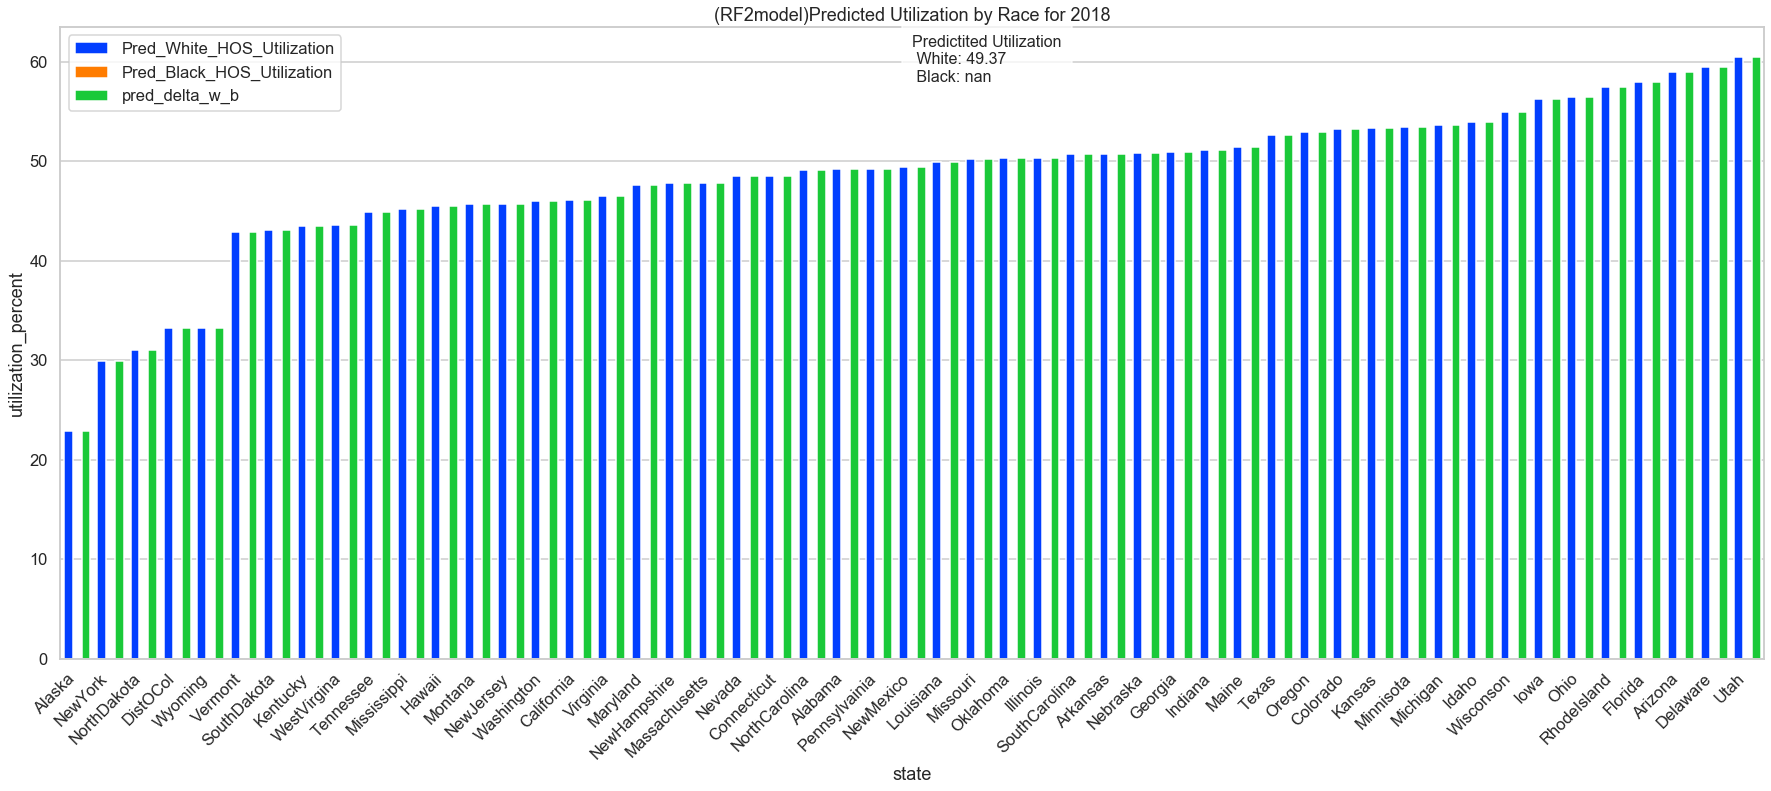

In [49]:
# Calculate the nation utilization numbers
Pred_white_nat_utilisation = summary_data.Pred_White_HOS_deceased.sum() / summary_data.Pred_White_deceased.sum()
Pred_black_nat_utilisation = summary_data.Pred_Black_HOS_deceased.sum() / summary_data.Pred_Black_deceased.sum()

#plot the Figure
plt.figure(figsize=(25,10))
sns.set_context('talk')
sns.set_style('whitegrid')
# create plot
sns.barplot(x = 'state', y ='utilization_percent' ,
            hue = 'race',
            data = temp,
            palette = 'bright',
            #order = ['male', 'female'],  
            capsize = 0.05,             
            saturation = 8,             
            ci = None,   
            )
plt.text(25,58, f'Predictited Utilization\n White: {round(Pred_white_nat_utilisation*100,2)}\n Black: {round(Pred_black_nat_utilisation*100,2)} ',
         style='normal',bbox={'facecolor':'white', 'alpha':0.75, 'pad':10},fontsize=16)
plt.legend(loc='best')
plt.tight_layout()
plt.title('(RF2model)Predicted Utilization by Race for 2018')
plt.xticks(rotation = 45, ha='right')
plt.savefig(f'E:/PatrickBernard/figures/RF_Class/model2/RF2model_PredictedUtilizationByState2018.png',bbox_inches = 'tight')

**Note**  
this model did not classify any of the benificiaries. when I review the models I believe tht sparcity is part of the porblem.